In [1]:
import mamba_ssm
from nnsight import LanguageModel, util
from nnsight.tracing.Proxy import Proxy
from nnsight.models.Mamba import MambaInterp
from transformers import AutoTokenizer
import numpy as np
import torch as t
import torch.nn.functional as F
import einops
from tqdm import tqdm
from functools import partial
from datasets import load_dataset
from torch.utils.data import DataLoader
from scipy.signal import find_peaks
from rich import print as rprint
from rich.table import Table
from matplotlib import pyplot as plt
from typing import List, Callable, Union

device = t.device("cuda:2" if t.cuda.is_available() else "cpu")

/mnt/ssd-1/gpaulo/miniconda3/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b", padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id
mamba_model = MambaInterp("state-spaces/mamba-2.8b", device=device, tokenizer=tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
dataset = load_dataset("JeanKaddour/minipile", data_dir="data")
val_dataset = dataset["validation"]
val_dataloader = DataLoader(val_dataset, batch_size=30, shuffle=False)


# Testrun

In [9]:
deltas = []
input_ids = []
for i in [0,5]:    
    batch = val_dataset[i]
    input_ids.append(tokenizer(batch["text"], return_tensors="pt").input_ids.to(device))  
    part_delta =[]
    with mamba_model.invoke(batch["text"],scan=True) as invoker:
        for i in range(0,64):
            delta = mamba_model.backbone.layers[i].mixer.dt.output.softplus.save()
            part_delta.append(delta)
        pass   
    deltas.append(part_delta) 


KeyboardInterrupt: 

In [ ]:
filler_target_ids = t.arange(0,25,device=device)
filler_indices = []
non_filler_indices = []
for i in range(10):
    filler_idx = t.arange(0, input_ids[i].size(1), device=device)[t.isin(input_ids[i],filler_target_ids)[0]]
    non_filler_idx = t.arange(0, input_ids[i].size(1), device=device)[~t.isin(input_ids[i],filler_target_ids)[0]]
    filler_indices.append(filler_idx.cpu())
    non_filler_indices.append(non_filler_idx.cpu())

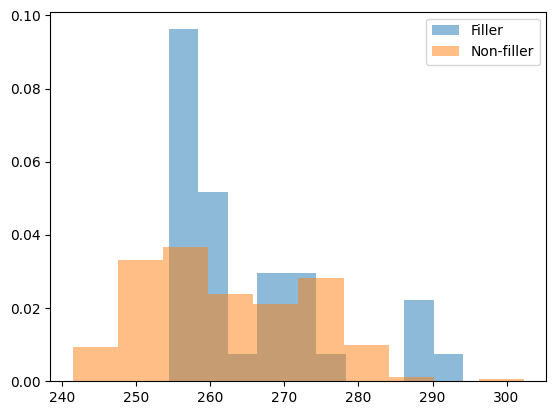

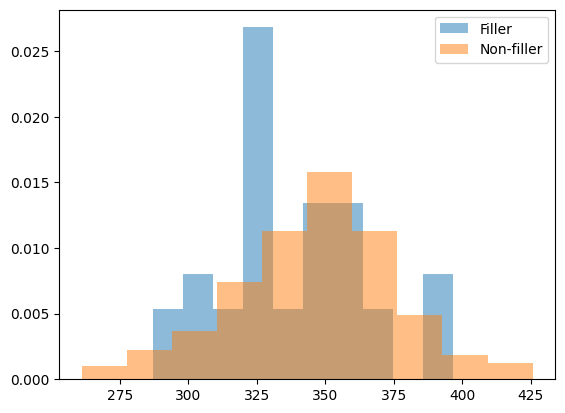

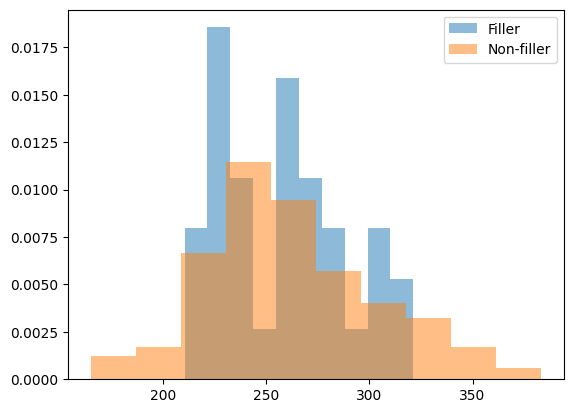

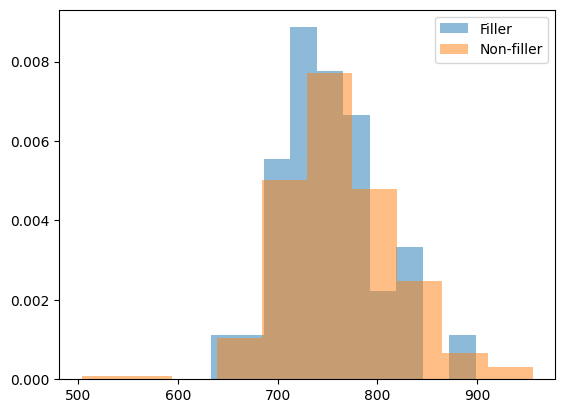

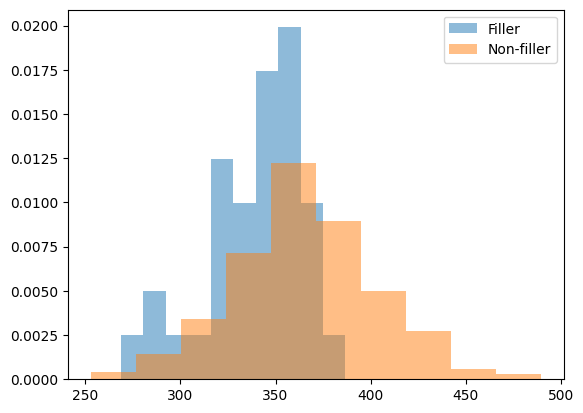

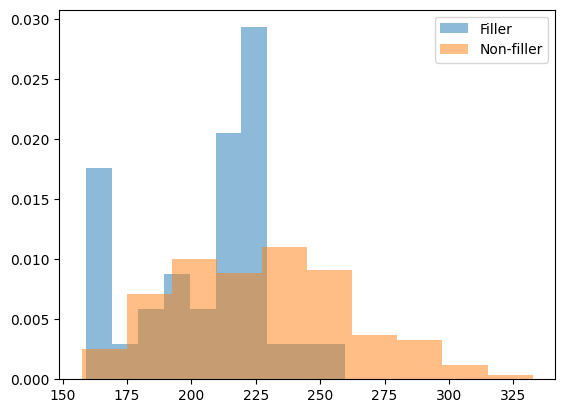

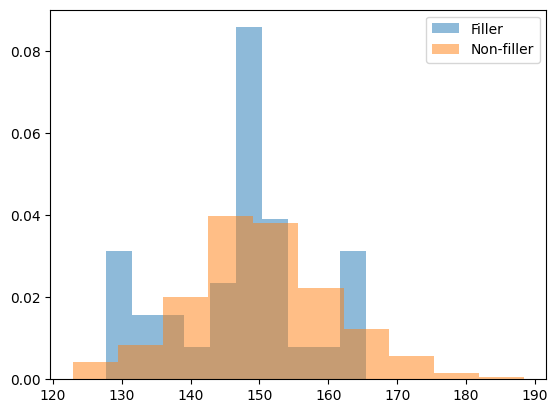

In [93]:

for layer in range(0,64,10):
    plt.figure()
    filler_magnitudes=[]
    non_filler_magnitudes=[]
    for i in range(10):
        delta = deltas[i][layer][0].cpu()
        filler_magnitude=t.norm(delta[:,filler_indices[i]],dim=0)
        non_filler_magnitude=t.norm(delta[:,non_filler_indices[i]],dim=0)
        filler_magnitudes.append(filler_magnitude)
        non_filler_magnitudes.append(non_filler_magnitude)
    filler_magnitudes = t.cat(filler_magnitudes,axis=0)
    non_filler_magnitudes = t.cat(non_filler_magnitudes,axis=0)

    plt.hist(filler_magnitude.value.numpy(), bins=10, alpha=0.5, label=f"Filler",density=True)
    plt.hist(non_filler_magnitude.value.numpy(), bins=10, alpha=0.5, label=f"Non-filler",density=True)
    #print(f"Layer {layer} magnitude: {average_magnitude.item()} +- {std_magnitude.item()}")
    #average_magnitude = t.mean(magnitude)
    #std_magnitude = t.std(magnitude)
    plt.legend()

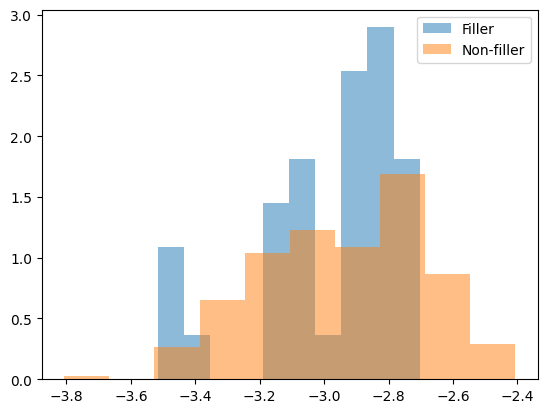

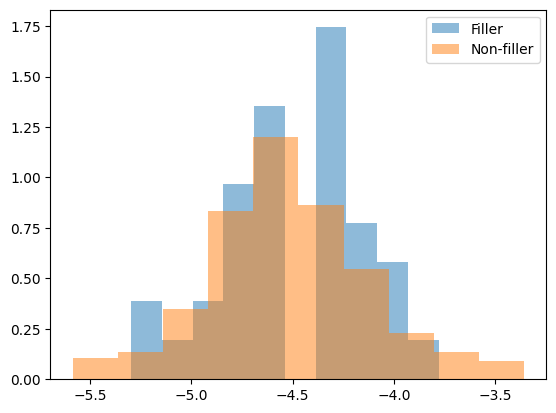

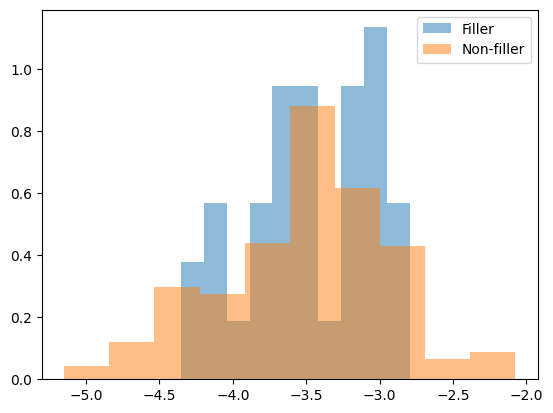

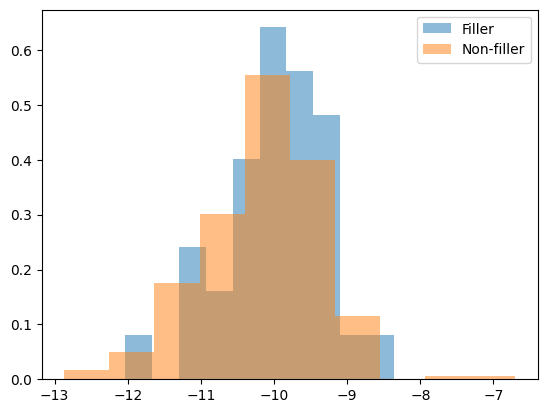

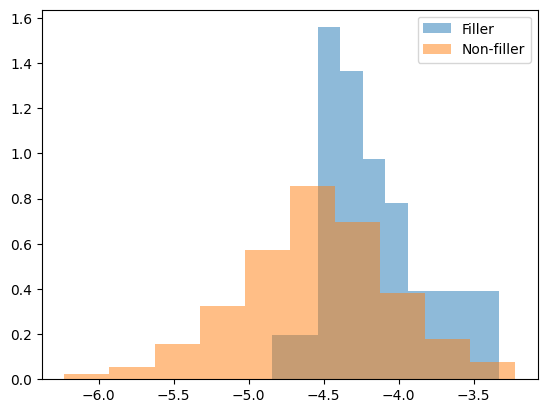

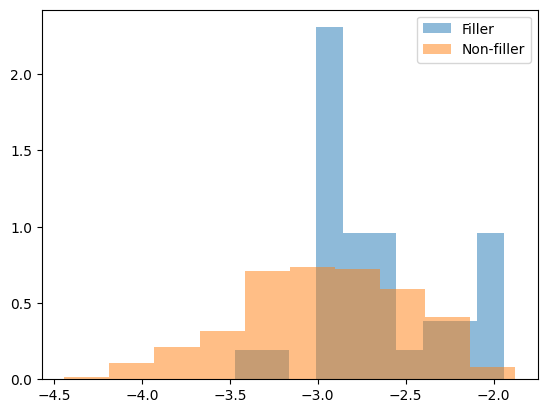

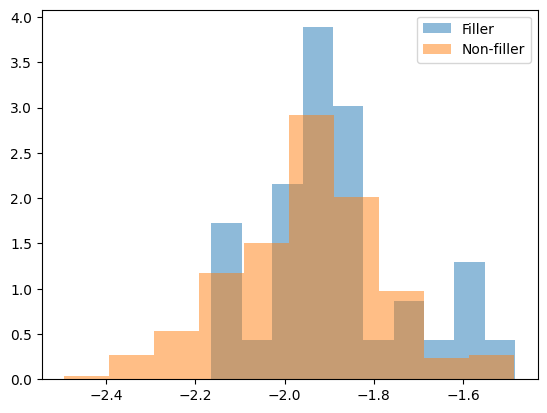

In [94]:
for layer in range(0,64,10):
    plt.figure()
    filler_magnitudes=[]
    non_filler_magnitudes=[]
    for i in range(10):
        delta = deltas[i][layer][0].cpu()
        filler_magnitude=t.mean(delta[:,filler_indices[i]],dim=0)
        non_filler_magnitude=t.mean(delta[:,non_filler_indices[i]],dim=0)
        filler_magnitudes.append(filler_magnitude)
        non_filler_magnitudes.append(non_filler_magnitude)
    filler_magnitudes = t.cat(filler_magnitudes,axis=0)
    non_filler_magnitudes = t.cat(non_filler_magnitudes,axis=0)

    plt.hist(filler_magnitude.value.numpy(), bins=10, alpha=0.5, label=f"Filler",density=True)
    plt.hist(non_filler_magnitude.value.numpy(), bins=10, alpha=0.5, label=f"Non-filler",density=True)
    #print(f"Layer {layer} magnitude: {average_magnitude.item()} +- {std_magnitude.item()}")
    #average_magnitude = t.mean(magnitude)
    #std_magnitude = t.std(magnitude)
    plt.legend()

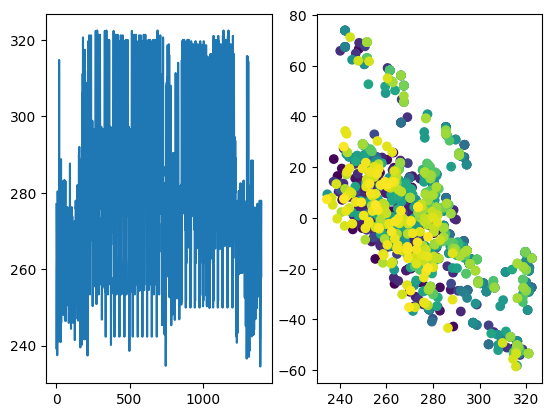

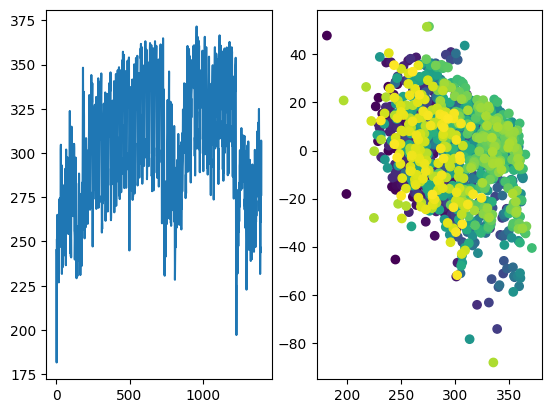

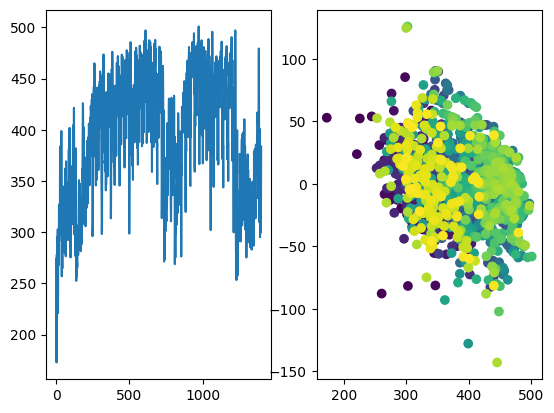

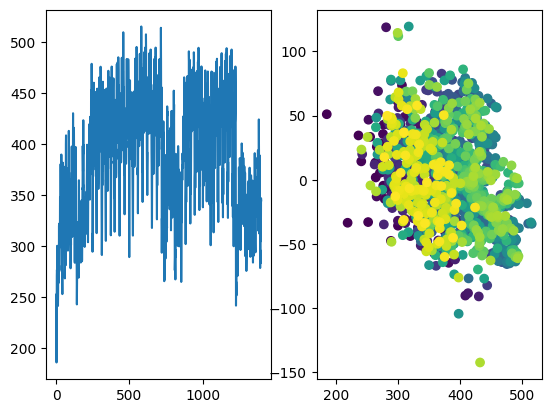

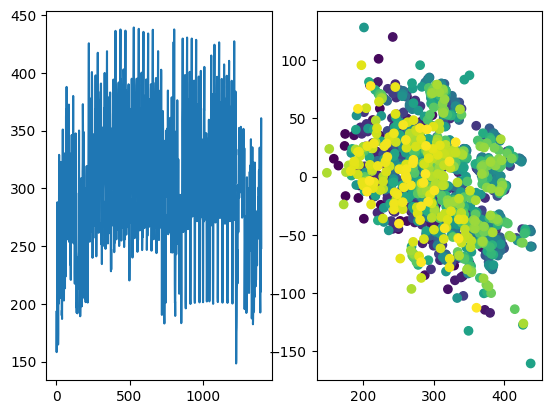

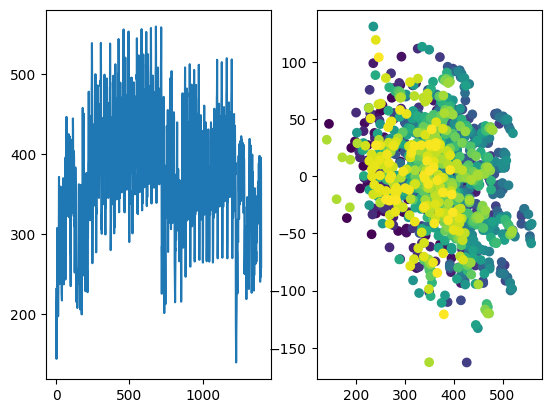

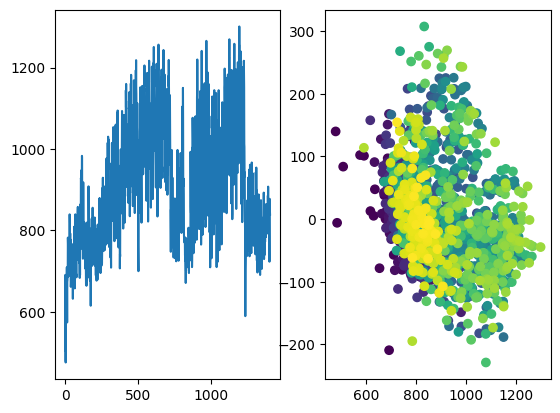

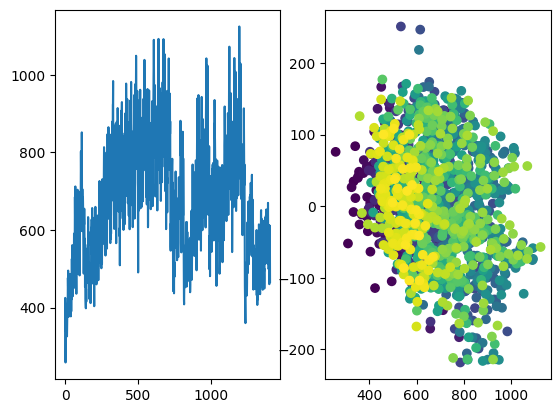

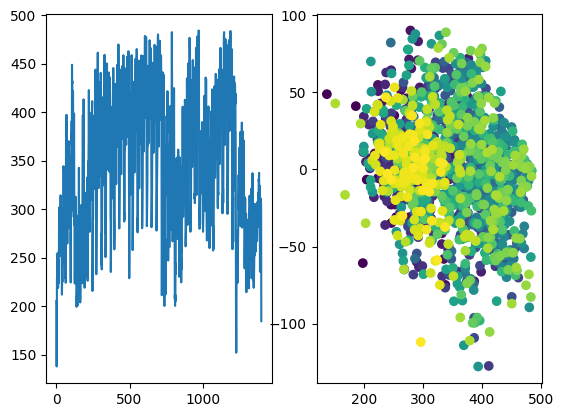

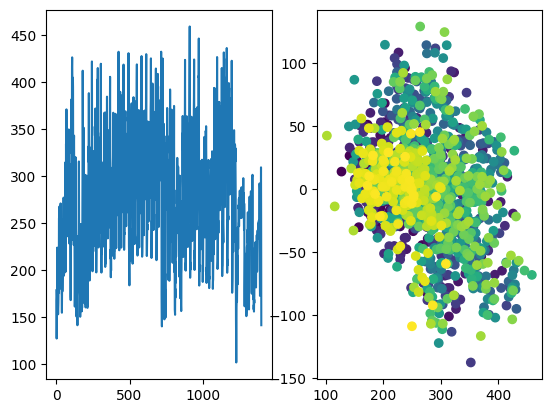

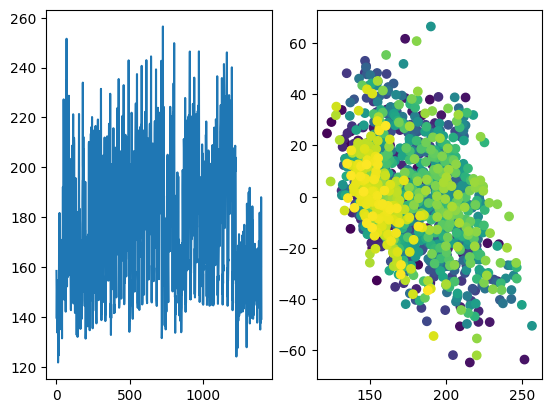

In [95]:

for layer in range(0,64,5):
    fig,ax=plt.subplots(1,2)
    magnitudes=[]
    #for i in range(5):
    i=0
    delta = deltas[i][layer][0].cpu()
    magnitude=t.norm(delta,dim=0)
    magnitude=magnitude.value.numpy()
    derivative=np.diff(magnitude)
    ax[0].plot(magnitude)
    time = np.arange(0, len(magnitude)-1)
    ax[1].scatter(magnitude[:-1],derivative,c=time)
    #plt.legend()

In [15]:
moving_average = lambda x, w: np.convolve(x, np.ones(w), 'valid') / w

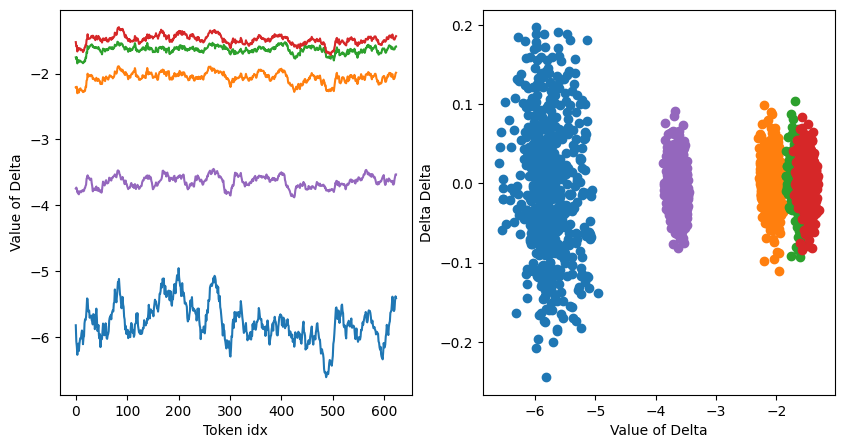

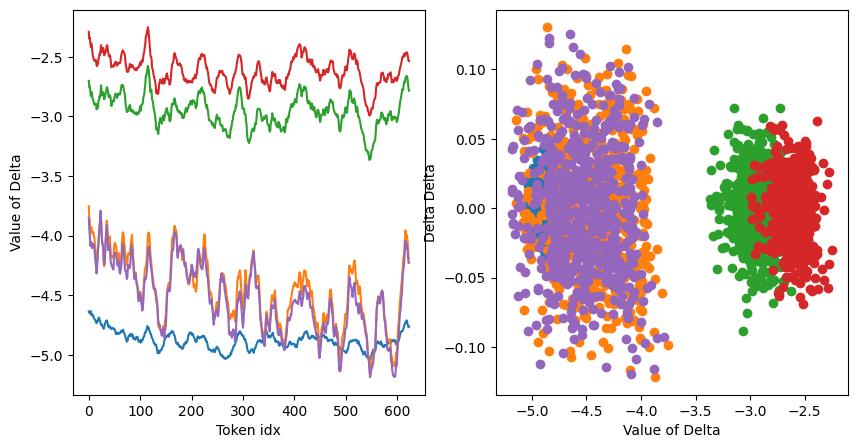

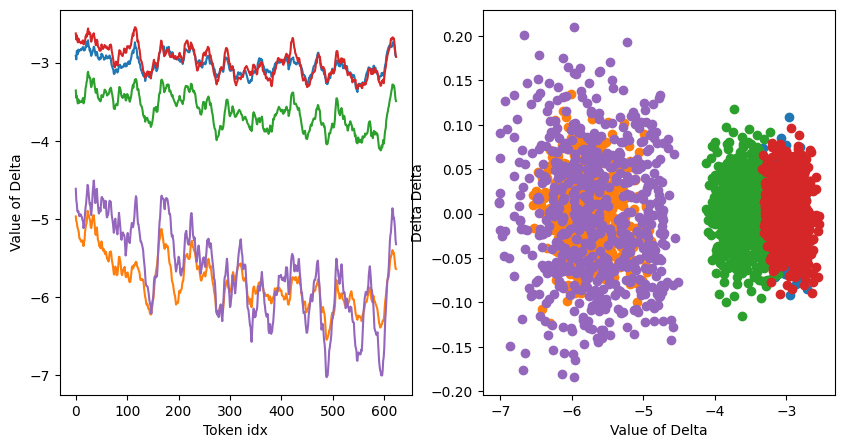

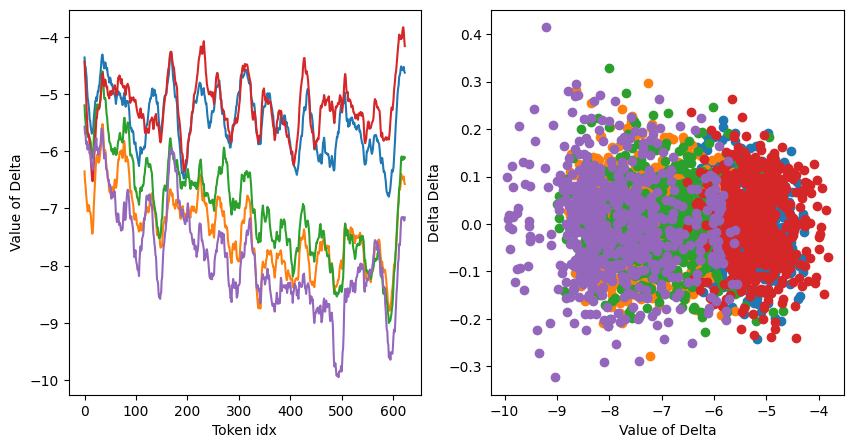

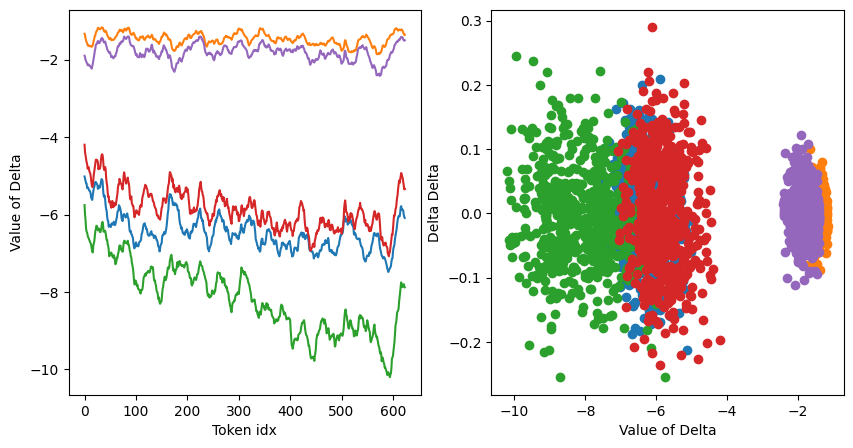

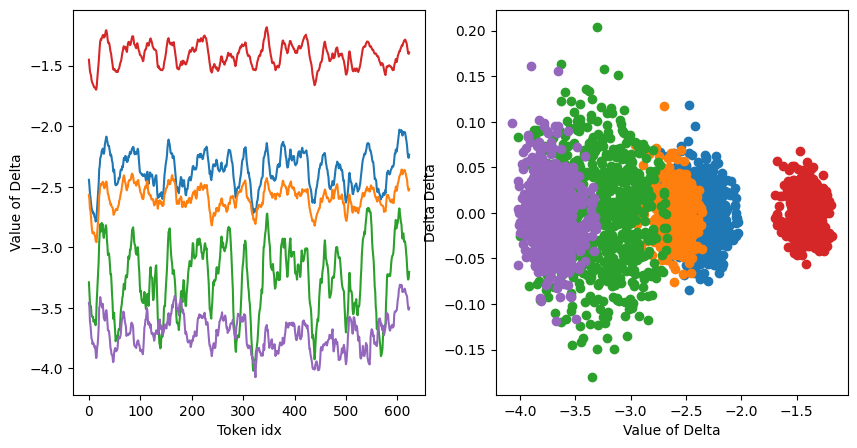

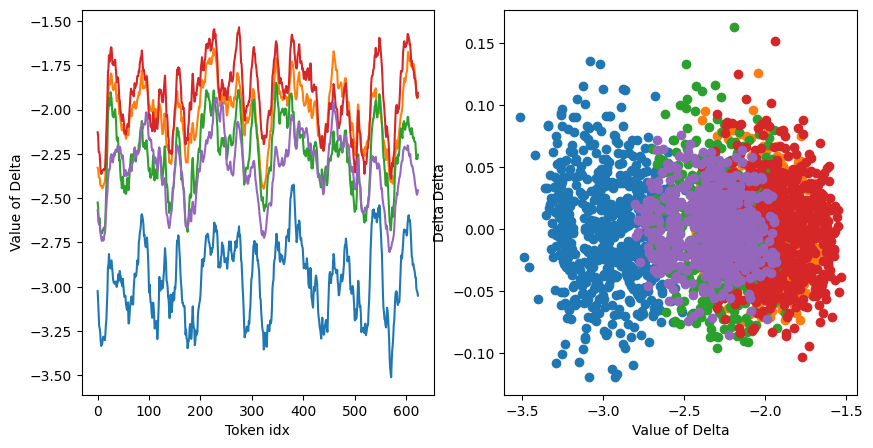

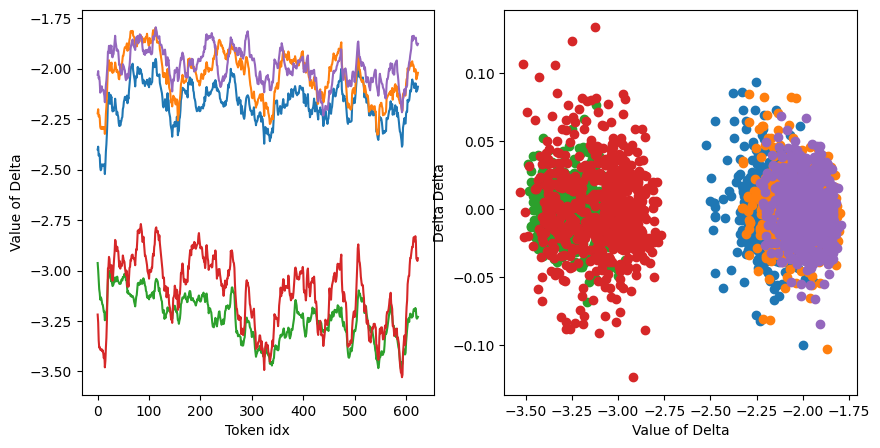

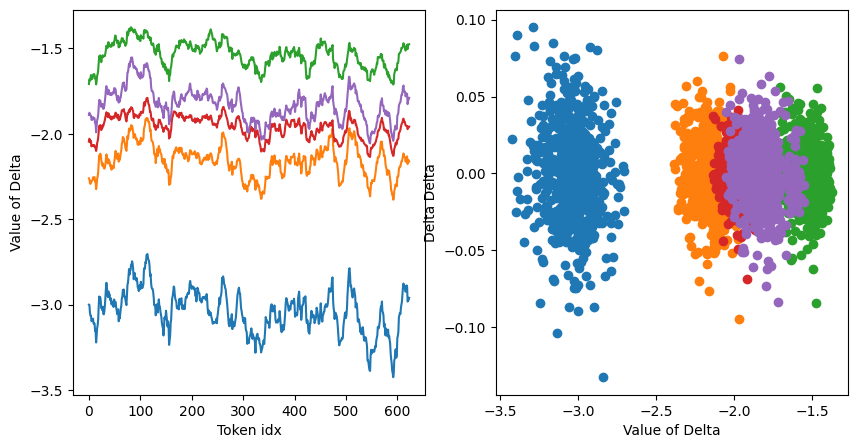

In [102]:
for layer in range(0,64,5):
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    magnitudes=[]
    #for i in range(5):
    i=5
    delta = deltas[i][layer][0][::1000].value.cpu().T
    
    for i in range(5):
        x = moving_average(delta[:,i],20)
        ax[0].plot(x)
        #time = np.arange(0, len(delta)-1)
        derivative=np.diff(x)
        ax[1].scatter(x[:-1],derivative)
        ax[0].set_xlabel("Token idx")
        ax[0].set_ylabel("Value of Delta")
        ax[1].set_xlabel("Value of Delta")
        ax[1].set_ylabel("Delta Delta")
        
    #plt.legend()

In [32]:
idx = np.random.randint(0,5120,size=2)
        
for layer in range(0,64,60):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    i=5
    
    for j in range(2):
        delta = deltas[i][layer][0][idx[j]].value.cpu().numpy().T

        low_peaks = find_peaks(delta,distance=100)[0]
        high_peaks = find_peaks(-delta,distance=100)[0]
        x=np.arange(0,len(delta))
        max_delta=1#np.max(delta)
        min_delta=0np.min(delta)
        for lp in low_peaks:
            string = tokenizer.decode(input_ids[i][0][lp]) 
            position=(delta[lp]-min_delta)/(max_delta-min_delta)
            ax[j].text(x[lp],position,string)
            ax[j].scatter(x[lp],position)
        for hp in high_peaks:
            string = tokenizer.decode(input_ids[i][0][hp]) 
            position=(delta[hp]-min_delta)/(max_delta-min_delta)
            ax[j].text(x[hp],position,string)
            ax[j].scatter(x[hp],position)
        #delta = moving_average(delta,10)
        max_delta=np.max(delta)
        min_delta=np.min(delta)
        ax[j].plot((delta-min_delta)/(max_delta-min_delta))    
    
    #plt.legend()

SyntaxError: invalid decimal literal (840139307.py, line 14)

In [4]:
deltas = []
input_ids = []
for i in [5]:    
    batch = val_dataset[i]
    input_ids.append(tokenizer(batch["text"], return_tensors="pt").input_ids.to(device))  
    part_delta =[]
    with mamba_model.invoke(batch["text"],scan=True) as invoker:
        for i in range(0,64):
            delta = mamba_model.backbone.layers[i].mixer.ssm.discA.output.save()
            part_delta.append(delta)
        pass   
    non_gpu = [part.value.cpu() for part in part_delta]
    part_delta=[]
    t.cuda.empty_cache() 
    deltas.append(non_gpu) 


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [37]:
batch["text"]

'Q:\n\n"Enable Wifi" not showing\n\nI recently used sudo apt-get autoremove command and after that "Enable Wifi" option is not showing.\n$ lspci -knn | grep Net -A3\n02:00.0 Network controller [0280]: Realtek Semiconductor Co., Ltd. RTL8821AE 802.11ac PCIe Wireless Network Adapter [10ec:8821]\n    Subsystem: Lenovo RTL8821AE 802.11ac PCIe Wireless Network Adapter [17aa:a814]\n    Kernel modules: rtl8821ae, wl\n\n$ iwconfig is\nlo no wireless extensions.\n\nenp1s0    no wireless extensions.\n\nFrom /var/apt/history.log:\nStart-Date: 2017-11-06  01:15:38\nCommandline: apt-get autoremove\nRequested-By: praveen (1000)\nRemove: linux-headers-4.10.0-28-generic:amd64 (4.10.0-28.32~16.04.2), librpmsign3:amd64 (4.12.0.1+dfsg1-3build3), linux-image-extra-4.10.0-33-generic:amd64 (4.10.0-33.37~16.04.1),\nlibrpmbuild3:amd64 (4.12.0.1+dfsg1-3build3),\nlinux-image-extra-4.10.0-35-generic:amd64 (4.10.0-35.39~16.04.1),\ndebugedit:amd64 (4.12.0.1+dfsg1-3build3),\nlinux-headers-4.10.0-33-generic:amd64 (4

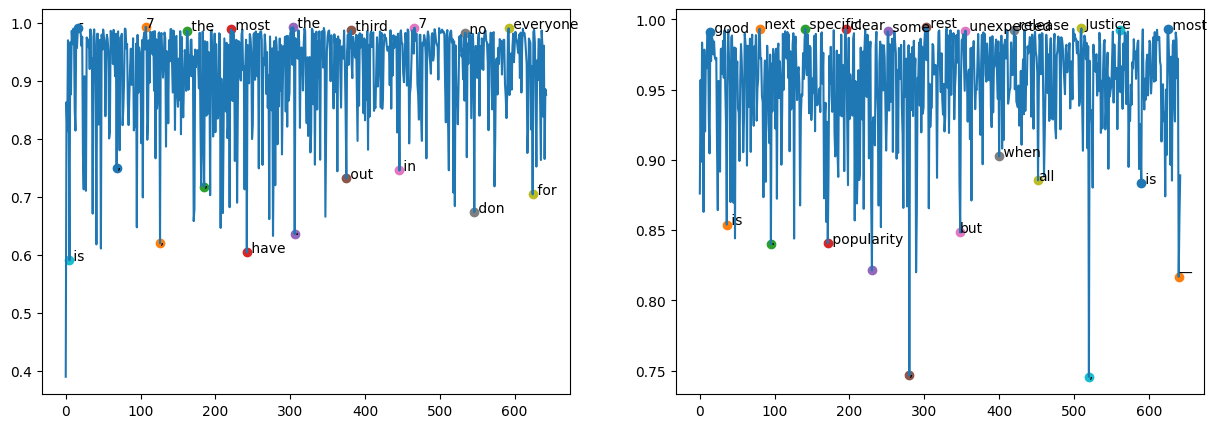

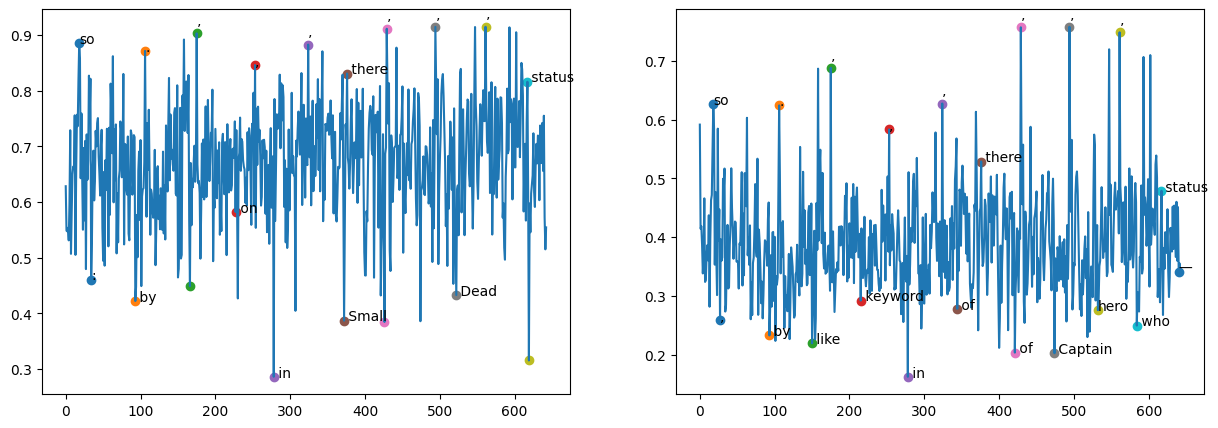

In [13]:
idx = [0,2500]
        
for layer in range(0,64,60):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    i=0
    
    for j in range(2):
        delta = deltas[i][layer][0][idx[j]].numpy()
        delta=np.mean(delta,axis=1)
        low_peaks = find_peaks(delta,distance=50)[0]
        high_peaks = find_peaks(-delta,distance=50)[0]
        x=np.arange(0,len(delta))
        max_delta=1#np.max(delta)
        min_delta=0#np.min(delta)
        for lp in low_peaks:
            string = tokenizer.decode(input_ids[i][0][lp]) 
            position=(delta[lp]-min_delta)/(max_delta-min_delta)
            ax[j].text(x[lp],position,string)
            ax[j].scatter(x[lp],position)
        for hp in high_peaks:
            string = tokenizer.decode(input_ids[i][0][hp]) 
            position=(delta[hp]-min_delta)/(max_delta-min_delta)
            ax[j].text(x[hp],position,string)
            ax[j].scatter(x[hp],position)
        #delta = moving_average(delta,10)
        max_delta=1#np.max(delta)
        min_delta=0#np.min(delta)
        ax[j].plot((delta-min_delta)/(max_delta-min_delta))    
    
    #plt.legend()

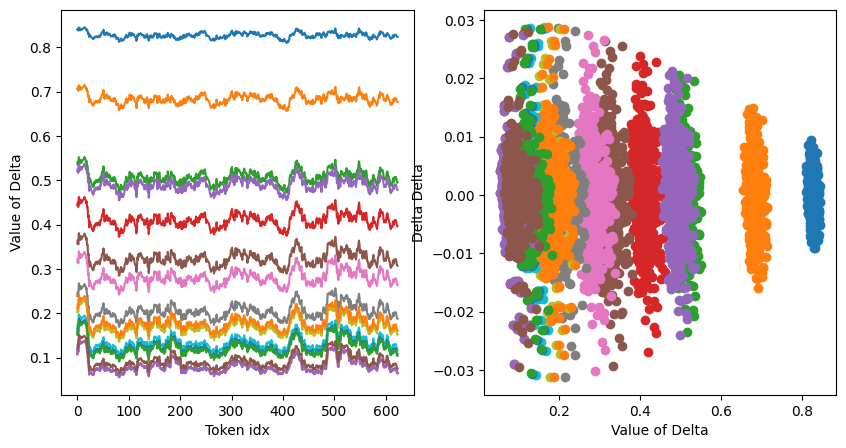

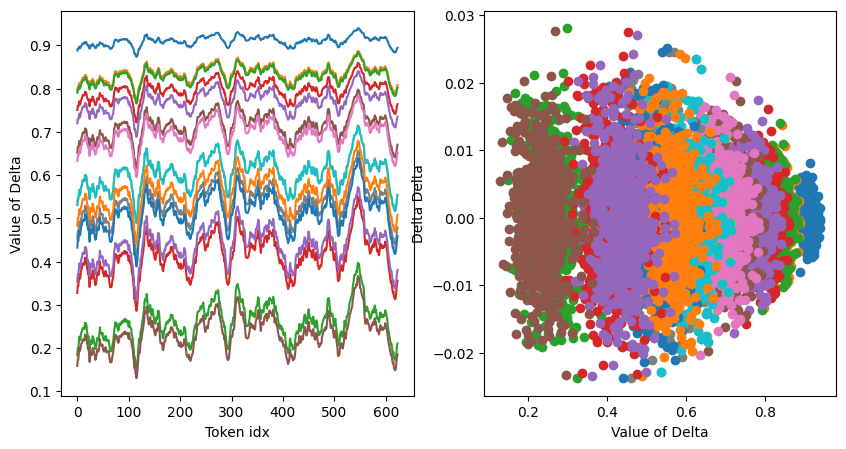

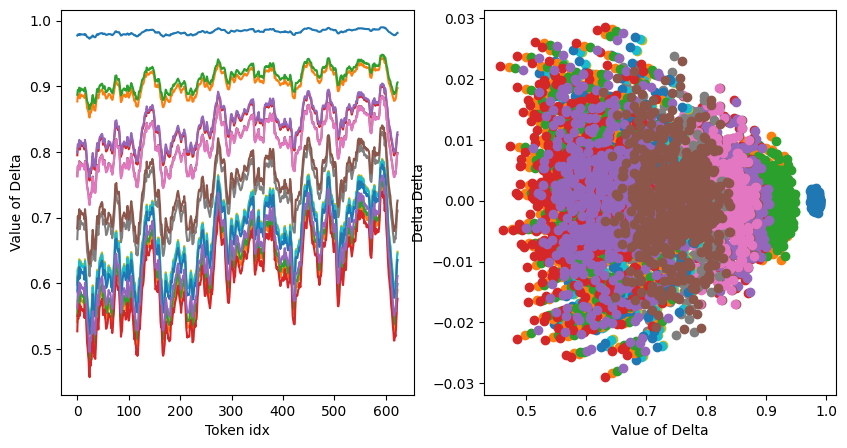

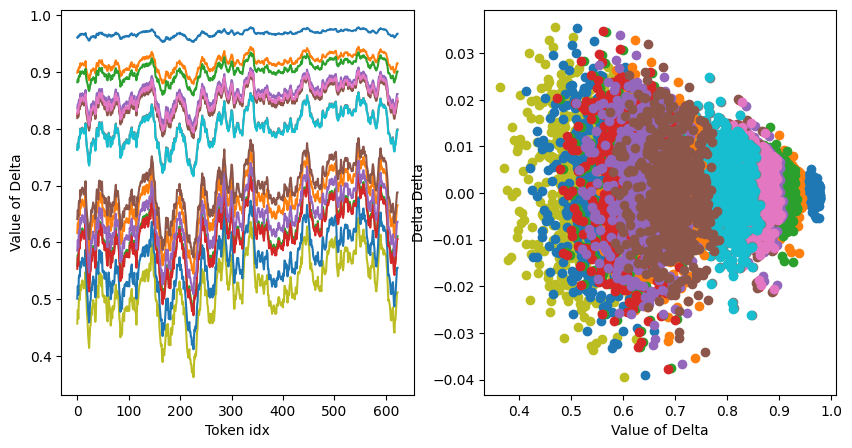

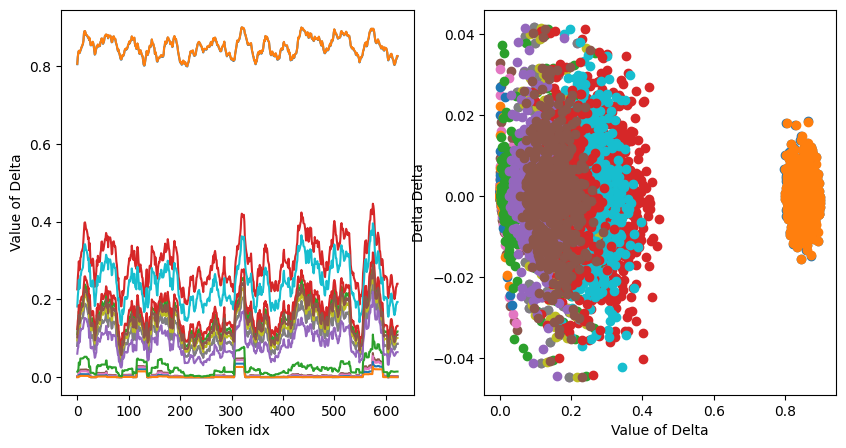

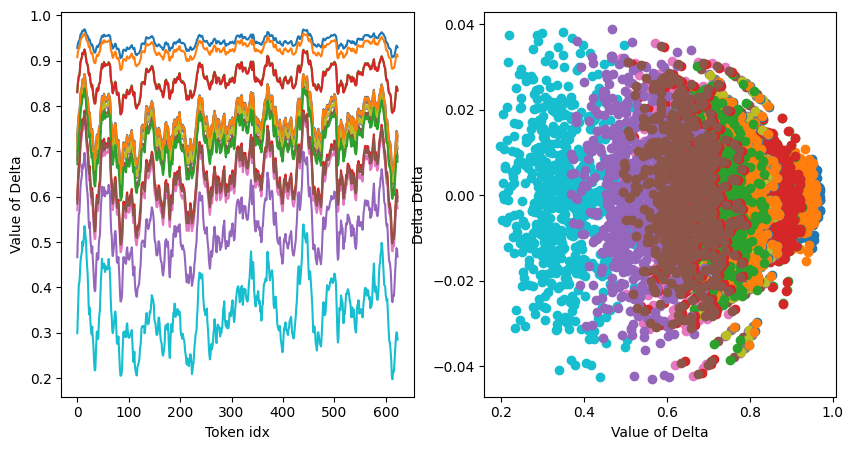

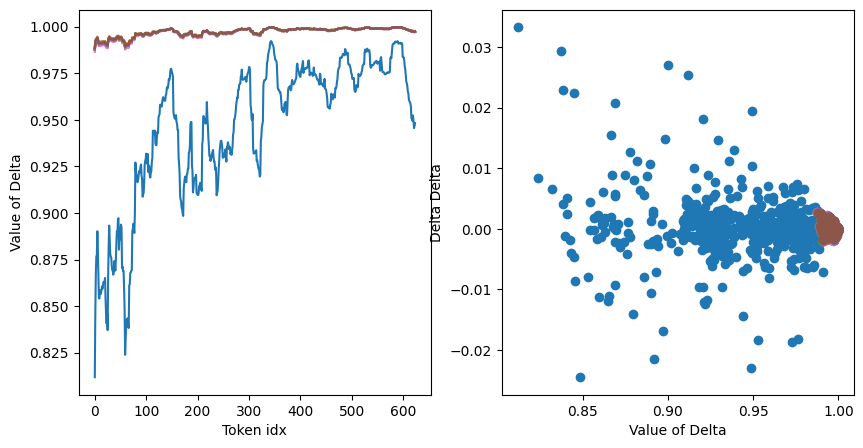

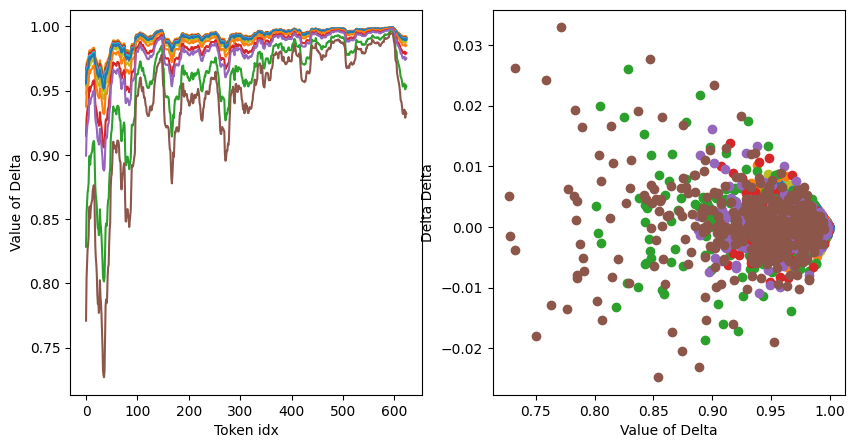

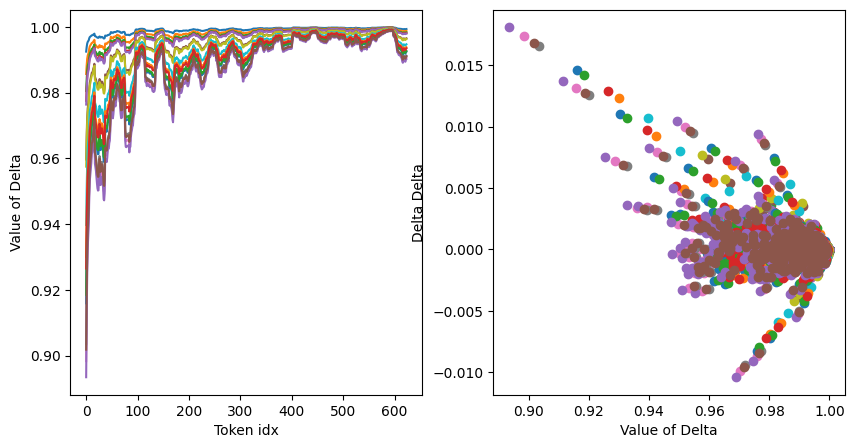

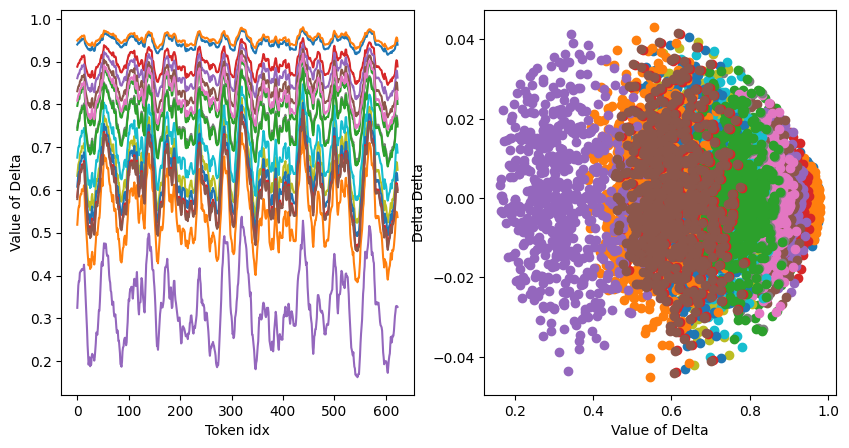

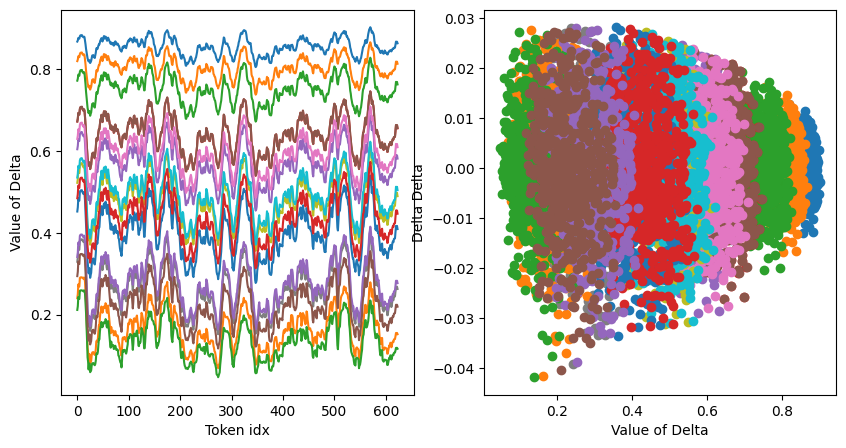

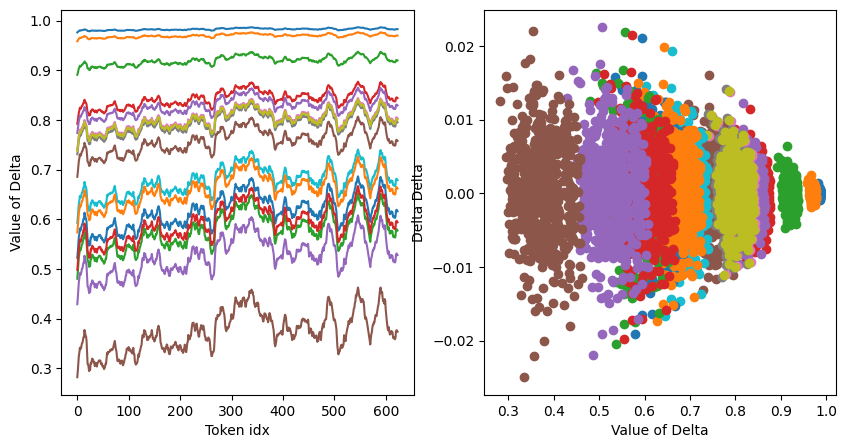

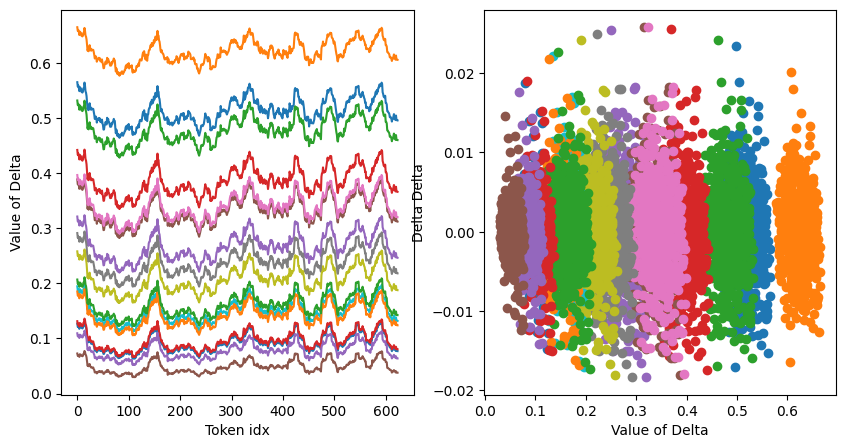

In [25]:
for layer in range(0,64,5):
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    i=0
        
    delta = deltas[i][layer][0][::1000].numpy()
    
    for i in range(16):
        x = moving_average(delta[2,:,i],20)
        ax[0].plot(x)
        #time = np.arange(0, len(delta)-1)
        derivative=np.diff(x)
        ax[1].scatter(x[:-1],derivative)
        ax[0].set_xlabel("Token idx")
        ax[0].set_ylabel("Value of Delta")
        ax[1].set_xlabel("Value of Delta")
        ax[1].set_ylabel("Delta Delta")
        
    #plt.legend()

In [19]:
delta.shape

(6, 643, 16)